# Symplectic integrators

## Exercise 1 
In this exercise we investigate the properties of several numerical integration applied to Hamilton's equation: 
$$
\begin{equation}
\begin{aligned}
\dot{q} &= p, \\ \dot{p} &= -\nabla U (q),
\end{aligned}
\end{equation}
$$
where $ U : \mathbb{R}^n \rightarrow \mathbb{R}$ is a smooth potential function.
In the morning lecture several properties of the group of flow maps $$(\Phi_t)_{t \in \mathbb{R}},$$ associated with the above equation where discussed. Besides being symplectic, $\Phi_t$ satisfies the following properties: For any $t \in \mathbb{R}$ 
- $\Phi_t$ is energy conserving, i.e.,  $$H(q,p) = H(\Phi_t(q),\Phi_t(p))$$ for all $q,p\in \mathbb{R}^n$
- $\Phi_t$ is time reversible in the sense that $$(\Phi_t)^{-1} = \Phi_{-t}.$$

- $\Phi_t$ is volume preserving, i.e., 
$$\int_{\mathbb{R}^n \times \mathbb{R}^n} {\bf 1}_{\Phi_t(S)}(q,p) d q d p = \int_{\mathbb{R}^n \times \mathbb{R}^n} {\bf 1}_{S}(q,p) d q d p$$ for all measureable $S \subset \mathbb{R}^n \times \mathbb{R}^n$.

Let $\widehat{\Phi}_h$ denote the flow map of the discretized dynamics, i.e.,
$$(q_{n+1}, p_{n+1}) = \widehat{\Phi}_h(q_{n}, p_{n}),$$
where $h$ denotes the step size of the time discretization.
The properties are not necessarily inherited by the flow map $\widehat{\Phi}_h$ of the discretized dynamics. In what follows we will assess by numerical experiments which of the above properties are preserved in the case of the discretized dynamics when 
- the Standard Euler method 
- the Symplectic Euler method 
- the Velocity Verlet method 

is used. 

## Task:

- asses whether the energy and volume conservation properties and the time reversibility are satisfied for the standard Euler scheme by running the code fragments in the cells below

- implement the symplectic Euler scheme and the Velocity Verlete scheme as subclasses of the class integrators.HamDynIntegrator. You only need to redefine the function `traverse()` in the class definition. See the implementation of `integrators.EulerHamDyn` to see how this is done. You can find a detailed description of both schemes in Ben's book. 

- Verify the energy and volume conservation properties as well as the time reversibility of the Symplectic Euler scheme 
- Implement a new class `LJoscillator` as a subclass `model` implementing a simple Lennar-Jones oscillator, which for $q>0$ is defined by the potential energy
$$U(q) = 4\epsilon \left [ \left(\frac{q}{\sigma}\right )^{12} - \left(\frac{q}{\sigma}\right )^{6} \right]$$
with $\epsilon>0$ and $\sigma>0$ being positive constants. Use the following constructor for in your class definition `def __init__(self, epsilon=np.array(1), sigma=np.array(1)):
        super(HarmonicOscillator,self).__init__(dim=epsilon.shape[0])
           
        self.epsilon = epsilon
        self.sigma = sigma`
  

In [22]:
# Import the relevant modules from miniMD 
import miniMD2.models as models
import miniMD2.integrators as integrators
import miniMD2.outputshedulers as outp
# Import the numpy package
import numpy as np
# Import the pyplot package (we will need this later to create plots)
import matplotlib.pyplot as plt

## Standard Euler
We first take a look at the properties of the simplest integration scheme
$$
\begin{aligned}
q_{n+1} &= q_n + p_n, \\ p_{n+1} &= p_n -\nabla U (q_n).
\end{aligned}
$$
You can find an implementation of this scheme in the box below


In [23]:
dim = 1
model = models.HarmonicOscillator(stiffness=np.ones(dim), rp=None)
integrator = integrators.EulerHamDyn(model, stepsize=.1)

#Initialising an outputsheduler. The 
op= outp.BufferedOutputshedulerU(integrator, Nsteps=1000, varname_list=['position','momentum'], modprnt=1)


initial_values={'momentum': np.array([1.0]), 'position': np.array([0.0])}

integrator.run(initial_values=initial_values)

### 1) Energy conservation
This doesn't look good. Instead of moving on a periodic trajectory the particle is spiralling out. This is not the physical behaviour we would expect from a Hamiltonian system. Indeed, the non periodicity of the particle position and the particle momentum suggests that the total energy (Hamiltonian) of the system
$$H(q,p) = U(q)+\frac{1}{2}\|p\|_2^2$$ 
is not conserved under the discretised dynamics. Demonstrate this by creating a plot of the form Timestep vs. Error in Total energy by filling out the missing parts in the code below:

(Hint: The potential energy is already collected by the outputsheduler. You can access the resulting trajectory as `op.traj_U`)

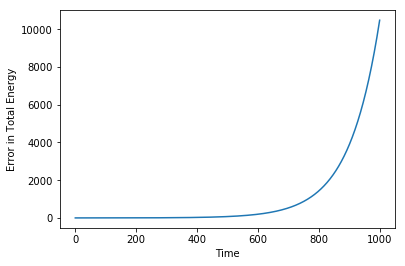

In [24]:
fig, ax = plt.subplots()
E0 = .5*np.sum(op.traj_momentum**2,axis=1)[0]+op.traj_U[0]
traj_Energy = .5*np.sum(op.traj_momentum**2,axis=1)+op.traj_U
ax.plot(traj_Energy  - E0)
ax.set_xlabel('Time')
ax.set_ylabel('Error in Total Energy')
plt.show()

### 2) Volume preservation
In order to assess the volume preservation property, we place 100 particles on a circe in phase space and monitor the enclosed volume as the system is evolved in time under the disrete dynamics:

In [31]:
# Specify model
model = models.HarmonicOscillator(stiffness=np.ones(dim), rp=None)
# Initialise integrator
integrator = integrators.EulerHamDyn(model, stepsize=.1)
# Initialise Outputsheduler
op= outp.BufferedOutputshedulerU(integrator, Nsteps=300, varname_list=['position','momentum'], modprnt=1)
# Initialise particles on a disc
dim =100
alpha = np.linspace(0,2*np.pi,dim)
position0 = .5*np.cos(alpha)
momentum0= 1 + .5*np.sin(alpha)
initial_values={'momentum': momentum0, 'position': position0}
# Run simulation
integrator.run(initial_values=initial_values)

The following code fragment plots the enclosed volume at different points in time:

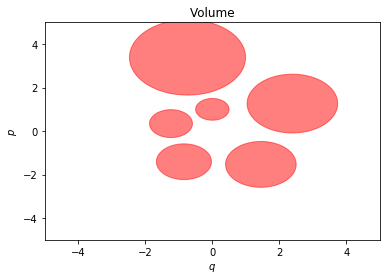

In [32]:
#%%
import matplotlib.animation as animation
import matplotlib.patches as patches

# Specify frequency at which volumes is plotted
modplot = 50  
# Spefiy figure properties
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlim(-5,5)
ax.set_ylim(-5,5)
ax.set_xlabel('$q$')
ax.set_ylabel('$p$')
ax.set_title('Volume')


#Plot volumes
t_vec = np.arange(0,op.Nsteps,modplot)
for i in t_vec:
    v= np.array([op.traj_position[i,:], op.traj_momentum[i,:]]).transpose()
    go= patches.Polygon(v,closed=True, fc='r', ec='r',alpha=.5)
    patch=ax.add_patch(go)
    
plt.show()

Plot the enclosed volume as a function of time. You can use the function `PolyArea(x,y)` defined below to compute the voume

In [33]:
def PolyArea(x,y):
    return 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))

### 3) Time reversibility
The below code generates 2 trajectories. First, one trajectory is generated by evolving the position and momenta of a particle starting at q=0,p=0 for 50 steps forward in time. Then, a second trajectory is generated starting at the last position in phase space of the first trajectory by evolving the system backward in time. What do we expect to happen for a time reversible dynamics, and what do we expect to happen for a not time reversible dynamics?

In [34]:
dim = 1
model = models.HarmonicOscillator(stiffness=np.ones(dim), rp=None)
#sampler = VelocityVerlet(model, stepsize=.1)        
integrator = integrators.EulerHamDyn(model, stepsize=.1)

#Initialising an outputsheduler. The 
op_forward= outp.BufferedOutputshedulerU(integrator, Nsteps=50, varname_list=['position','momentum'], modprnt=1)
#Add the outputsheduler to the sampler
integrator.outputsheduler = op_forward
#Specify initial conditions
initial_values={'momentum': np.array([1.0]), 'position': np.array([0.0])}
#Simulate forward in time
integrator.run(initial_values=initial_values)

#Specify integrator which will simulate backward in time 

integrator = integrators.EulerHamDyn(model, stepsize=-.1)
#Initialising an outputsheduler used for the backward in time simultion
op_backward= outp.BufferedOutputshedulerU(integrator, Nsteps=50, varname_list=['position','momentum'], modprnt=1)
#Add the outputsheduler to the sampler
integrator.outputsheduler = op_backward
#Specify initial conditions
initial_values={'momentum': np.copy(op_forward.traj_momentum[-1,:]), 'position': np.copy(op_forward.traj_position[-1,:])}
#Simulate forward in time
integrator.run(initial_values=initial_values)

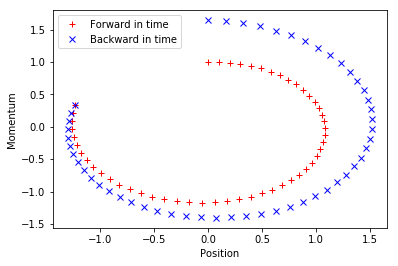

In [78]:
fig, ax = plt.subplots()
ax.plot(op_forward.traj_position,op_forward.traj_momentum,'r+',label="Forward in time")
ax.plot(op_backward.traj_position,op_backward.traj_momentum,'bx',label="Backward in time")
ax.legend()
ax.set_xlabel('Position')
ax.set_ylabel('Momentum')
plt.show()